In [58]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import LabelEncoder
from plotly.offline import init_notebook_mode
from datetime import timedelta
import plotly.graph_objects as go
from prophet import Prophet
from sklearn import metrics
import plotly.express as px
import lightgbm as lgb
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action="ignore")

In [59]:
df_one = pd.read_csv('time_series_covid_19_recovered.csv')

In [60]:
df_one.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,33,34,34,35,35,35,35,41,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,101,118,118,118,118,118,144,144,144,150
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,96,96,97,105,105,109,114,114,114
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,24,26,26,26,35,42,42,49,60,75


In [61]:
df_two=pd.read_csv("time_series_covid_19_deaths.csv")
df_two=pd.melt(df_two,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Deadths')
df_two.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
df_two['Date']=pd.to_datetime(df_two['Date'])

- We will prepare our dataset using `time_series_covid_19_recovered.csv`,`time_series_covid_19_confirmed.csv` and `time_series_covid_19_deaths.csv`.
- We will use `pd.melt` function to tranform the dataset to suitable format.

In [62]:
def melt_and_merge(agg=True):

    df_one = pd.read_csv('time_series_covid_19_recovered.csv')
    df_one=pd.melt(df_one,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Recovered')
    df_one.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
    df_one['Date']=pd.to_datetime(df_one['Date'])

    df_two=pd.read_csv("time_series_covid_19_deaths.csv")
    df_two=pd.melt(df_two,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Deaths')
    df_two.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
    df_two['Date']=pd.to_datetime(df_two['Date'])

    df_three=pd.read_csv("time_series_covid_19_confirmed.csv")
    df_three=pd.melt(df_three,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Confirmed')
    df_three.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
    df_three['Date']=pd.to_datetime(df_three['Date'])
    
    if (agg):
        col={"Lat":np.mean,"Long":np.mean,"Recovered":sum}
        df_one=df_one.groupby(['Country',"Date"],as_index=False).agg(col)
        
        col={"Lat":np.mean,"Long":np.mean,"Deaths":sum}
        df_two=df_two.groupby(['Country',"Date"],as_index=False).agg(col)
        
        col={"Lat":np.mean,"Long":np.mean,"Confirmed":sum}
        df_three=df_three.groupby(['Country',"Date"],as_index=False).agg(col)

    else:
        df_one['State'].fillna(df_one['Country'],inplace=True)
        df_two['State'].fillna(df_two['Country'],inplace=True)
        df_three['State'].fillna(df_three['Country'],inplace=True)
    
    
    print("The shape of three datasets are equal :",(df_three.shape[0]==df_one.shape[0]==df_two.shape[0]))
    
    merge=pd.merge(df_one,df_two)
    merge=pd.merge(merge,df_three)
    
    return merge

In [63]:
data=melt_and_merge(True)

The shape of three datasets are equal : True


In [64]:
data.head()

,Country,Date,Lat,Long,Recovered,Deaths,Confirmed
0,Afghanistan,2020-01-22,33.0,65.0,0,0,0
1,Afghanistan,2020-01-23,33.0,65.0,0,0,0
2,Afghanistan,2020-01-24,33.0,65.0,0,0,0
3,Afghanistan,2020-01-25,33.0,65.0,0,0,0
4,Afghanistan,2020-01-26,33.0,65.0,0,0,0


In [65]:
print("There are {} rows are {} columns in our data".format(data.shape[0],data.shape[1]))

There are 8990 rows are 7 columns in our data


In [66]:
print("The data starts from the date {} and ends in {}".format(data.Date.min().date(),data.Date.max().date()))
print("So we have {} of data".format(data.Date.max().date()-data.Date.min().date()))
print("From {} countries".format(data.Country.nunique()))

The data starts from the date 2020-01-22 and ends in 2020-03-19
So we have 57 days, 0:00:00 of data
From 155 countries


In [67]:
x=data.groupby(['Country'],as_index=False)['Deaths'].last().sort_values(by="Deaths",ascending=False)
fig=px.pie(x,"Country","Deaths")
fig.update_layout(title="Global Covid-19 Deaths")

- More than 50% of the cases and deadths are from China where the initial cases was reported.
- Italy is the second most affected country with 24% of global deadth.
- Iran follows Italy with 10% of global deadth reported.

In [68]:
df_four=pd.read_csv("COVID19_open_line_list.csv",usecols=['age','sex','province','country','wuhan(0)_not_wuhan(1)',
                                                                                              "latitude",'longitude'])
df_four.head()

,age,sex,province,country,wuhan(0)_not_wuhan(1),latitude,longitude
0,30,male,Anhui,China,1.0,31.646960,117.716600
1,47,male,Anhui,China,1.0,31.778630,117.331900
2,49,male,Anhui,China,1.0,31.828313,117.224844
3,47,female,Anhui,China,1.0,31.828313,117.224844
4,50,female,Anhui,China,1.0,32.001230,117.568100


In [69]:
df_four.sex.fillna('Unknown',inplace=True)
df_four.sex=df_four['sex'].map({"Female":"female","Male":"male","male":"male",'female':'female',"Unknown":"Unknown"})


In [70]:
sex= df_four.sex.value_counts()[1:]
fig=px.pie(sex,sex.index,sex)
fig.update_layout(title="Male vs Female infected Globally")

- The data contains many unknown values
- From the data we can conclude that more number of males were infected than females.

In [71]:
most_effected=data.groupby(['Country'],as_index=False)['Deaths'].last().sort_values(by="Deaths",ascending=False)[:10]
fig=px.bar(most_effected,x="Country",y="Deaths",title="Most affected countries by Number of Deaths")
fig.show()

In [72]:
most_effected=data.groupby(['Country'],as_index=False)['Confirmed'].last().sort_values(by="Confirmed",ascending=False)[:10]
fig=px.bar(most_effected,x="Country",y="Confirmed",title="Most affected countries by Number of Confirmed Cases")
fig.show()

- Most  number of the cases  are confirmed from China,followed by Italy,Iran and S.Korea.
- As you can see the numbers/cases in China is much higher than any other country.

In [73]:
most_affected=data.groupby(['Country'],as_index=False)['Recovered'].last().sort_values(by="Recovered",ascending=False)[:10]
fig=px.bar(most_affected,x="Country",y="Recovered",title="Most affected countries by Number of Recovered Cases")
fig.show()

 I saw an interesting fact here,Eventhough Italy has reported more cases than Iran,they lag behind Iran in the recovery rate.The same issue happends between S.Korea and  Spain too.

In [74]:
fig = go.Figure()
for country in ["China","Italy","Iran","Spain"]:
   

    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=data[data['Country']==country]['Confirmed'],
        name = country, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of number of Confirmed Cases") 
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)
fig.show()

- The COVID-19 cases strated increasing steeply from February.
- The cases started stabilising by March first week.
- At the same time the cases started increasing in other countries steaply.

In [75]:
fig = go.Figure()
for country in ['China',"Italy","Iran","Spain"]:
   

    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=data[data['Country']==country]['Deaths'],
        name = country, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of number of deaths")    
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)

fig.show()

In [76]:
fig = go.Figure()
for country in ['China',"Italy","Iran","Spain"]:
   

    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=data[data['Country']==country]['Confirmed'],
        name = country, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of number of Recovered Cases")  
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)
fig.show()

Almost the same pattern as above !

In [77]:
fig = go.Figure()
for country in ['China',"Italy","Iran"]:
   
    lag_1=data[data['Country']==country]['Confirmed'].shift(1)
    change=(data[data['Country']==country]['Confirmed']-lag_1).fillna(0)
    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=change,
        name = country, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of number of Confirmed cases each day")    
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)

fig.show()

- The above plot shows the number of confirmed cases reported per day,till this time we were looking at cumilative sum.
- The number cases increased exponentially in China on `Feb 13`.,Then it started falling down and in last day it rose it just 13.
- But incase of Italy the situation seems to be going worse by this time. More than 5k cases on `March 13`

Is `13` really a bad number ?

In [78]:
fig = go.Figure()
for country in ['China',"Italy","Iran"]:
   
    lag_1=data[data['Country']==country]['Deaths'].shift(1)
    change=(data[data['Country']==country]['Deaths']-lag_1).fillna(0)
    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=change,
        name = country, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of number of Deaths each day")   
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)

fig.show()

- Again `Feb 13` recorded most number of deadths in China and `March 13` on Italy !

In [79]:
locations=pd.read_csv("plotly_countries_and_codes.csv",usecols=['COUNTRY','CODE'])
df=pd.merge(data,locations,left_on=['Country'],right_on=['COUNTRY'],how="left")


In [80]:
df_country=df.groupby(['Country',"CODE"],as_index=False)[['Recovered',"Deaths","Confirmed"]].last()

In [81]:
fig = px.choropleth(df_country, locations="CODE",
                    color="Deaths", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title="Global COVID-19 Deaths")
fig.show()

In [82]:
fig = px.choropleth(df_country, locations="CODE",
                    color="Confirmed", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title="Global COVID-19 Confirmed Cases")
fig.show()

In [83]:
fig = px.choropleth(df_country, locations="CODE",
                    color="Recovered", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title="Global COVID-19 Recovered Cases")
fig.show()

In [84]:
china=data[data['Country']=="China"]
fig = go.Figure()
for i in ["Confirmed","Recovered","Deaths"]:
   

    fig.add_trace(go.Scatter(
        y=china[i],
        x=china['Date'],
        name = i, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of China ") 
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)

fig.show()

-  major outbreak occured on `Feb 13`th when the number of infected people rised heavily.
- Now the infeected and recovered cases slowly started convergig leaving a gap of 15k people.So almost 12k people are yet in the hospitals and 3k people died.

In [85]:
df=melt_and_merge(False)

The shape of three datasets are equal : True


In [86]:
china=df[df['Country']=="China"]
fig = go.Figure()
states=china.State.unique().tolist()
states.remove('Hubei')
for country in states:
   

    fig.add_trace(go.Scatter(
        x=china[china['State']==country]['Date'],
        y=china[china['State']==country]['Confirmed'],
        name = country, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of number of Confirmed Cases in Provinces except Hubei")  
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.update_traces(mode='lines', marker_line_width=2.5, marker_size=3)

fig.show()


- Hubei province is the most affected province
- followed by `Guangdong` and `Henan`
- `Macau` and `Tibet` are the least affected Provinces with less than 20 cases.

In [87]:
china=df[df['Country']=="China"]
fig = go.Figure()
states=china.State.unique().tolist()
states.remove('Hubei')
for country in states:
   

    fig.add_trace(go.Scatter(
        x=china[china['State']==country]['Date'],
        y=china[china['State']==country]['Deaths'],
        name = country, # Style name/legend entry with html tags
        connectgaps=True # override default to connect the gaps
    ))
fig.update_layout(title="Timeseries plot of number of Deaths Cases in Provinces except Hubei")
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

- `Henan` recorded second most number of deaths in China after `Hubei`

In [88]:
china=df[df['Country']=="China"].groupby(['State'],as_index=False)[[ 'Lat', 'Long', 'Date', 'Recovered', 'Deaths',"Confirmed"]].last()

In [89]:
fig=px.bar(china,x="State",y="Confirmed")
fig.update_layout(title="Confirmed Cases in Provinces of China")
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

- Hubei province in China has recorded the largest number of cases (67k).
- The highest number of cases in China is in the Hubei province, where the virus is believed to have originated.`Wuhan City` is located in this province.
- Within Hubei, the city of Wuhan accounts for the highest number of confirmed cases, followed by Zhejiang, Guangdong, and Hunan. The province registered a 30% spike in new confirmed cases of 14,840 on 13 February 2020.

In [90]:
Hubei=df[df['State']=="Hubei"]
Hubei.loc[:,'lag_1']=Hubei['Confirmed'].shift(1)
Hubei.loc[:,'Daily']=(Hubei['Confirmed']-Hubei['lag_1']).fillna(0).values
fig=px.bar(Hubei,x="Date",y="Daily")
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.update_layout(title="Daily Confirmed Cases in Hubei province")
fig.show()

In [91]:
Hubei=df[df['State']=="Hubei"]
Hubei.loc[:,'lag_1']=Hubei['Recovered'].shift(1)
Hubei.loc[:,'Daily']=(Hubei['Recovered']-Hubei['lag_1']).fillna(0)
fig=px.bar(Hubei,x="Date",y="Daily")
fig.update_layout(title="Daily recovered in Hubei province")
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()


In [92]:
Hubei=df[df['State']=="Hubei"]
Hubei.loc[:,'lag_1']=Hubei['Deaths'].shift(1)
Hubei.loc[:,'Daily']=(Hubei['Deaths']-Hubei['lag_1']).fillna(0)
fig=px.bar(Hubei,x="Date",y="Daily",)
fig.update_layout(title="Daily Deaths in Hubei province")
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

- Hubei also recorded the largest number of deaths due to covid-19 on `feb 13`.

- Let's check what happened in Rest of the world,against the condition of China.
- This would greatly reveal the trend in Countries such as Italy,Span,S. Korea,India etc..

In [93]:
restof_world=data[data['Country']!="China"].groupby(['Date'],as_index=False)[['Confirmed',"Recovered","Deaths"]].agg(sum)
china=data[data['Country']=="China"]

In [94]:

fig = go.Figure()
fig.add_trace(go.Bar(x=china['Date'],
                y=china['Confirmed'],
                name='China',
                marker_color='rgb(255, 0, 0)'
                ))
fig.add_trace(go.Bar(x=restof_world['Date'],
                y=restof_world['Confirmed'],
                name='Rest of world',
                marker_color='rgb(0, 0, 255)'
                ))

fig.update_layout(
    title='Global Confirmed Cases, China and Rest of World',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Confirmed Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')

fig.show()



- Cases started reporting in other countries outside China from `february 8th`.
- Since then,the cases has increased drastically in other Counties.
- But by the end of February the cases has stabilizied in China,but the situation has worsened in rest of the world.

In [95]:

fig = go.Figure()
fig.add_trace(go.Bar(x=china['Date'],
                y=china['Deaths'],
                name='China',
                marker_color='rgb(255, 0, 0)'
                ))
fig.add_trace(go.Bar(x=restof_world['Date'],
                y=restof_world['Deaths'],
                name='Rest of world',
                marker_color='rgb(0, 0, 255)'
                ))

fig.update_layout(
    title='Global Deaths China and Rest of World',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Death Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(250, 242, 242,0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')

fig.show()



- Since the transfer of the pandemic to other countries from china,the death rates have constantly increased.
- The death is is actually increasing in a dangerous manner as the first quarter in china.

In [96]:

fig = go.Figure()
fig.add_trace(go.Bar(x=china['Date'],
                y=china['Recovered'],
                name='China',
                marker_color='rgb(255, 0, 0)'
                ))
fig.add_trace(go.Bar(x=restof_world['Date'],
                y=restof_world['Recovered'],
                name='Rest of world',
                marker_color='rgb(0, 0, 255)'
                ))

fig.update_layout(
    title='Global Recovered Cases, China and Rest of World',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Recovered Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')

fig.show()


In [97]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Italy","Korea, South","Spain", "India",))

countries=["Italy","Korea, South","Spain", "India",]

    
country=data[data['Country']==countries[0]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Confirmed'],
                    marker=dict(color=country['Confirmed'], coloraxis="coloraxis")),
              1, 1)
    
country=data[data['Country']==countries[1]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Confirmed'],
                    marker=dict(color=country['Confirmed'], coloraxis="coloraxis")),
              1,2 )
    
country=data[data['Country']==countries[2]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Confirmed'],
                    marker=dict(color=country['Confirmed'], coloraxis="coloraxis")),
              2, 1)
    
country=data[data['Country']==countries[3]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Confirmed'],
                    marker=dict(color=country['Confirmed'], coloraxis="coloraxis")),
              2,2 )
fig.update_layout(title="Confirmed cases in Italy,S.Korea,Spain and India")

fig.show()   

In [98]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Italy","Korea, South","Spain", "India",))

countries=["Italy","Korea, South","Spain", "India",]

    
country=data[data['Country']==countries[0]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Deaths'],
                    marker=dict(color=country['Deaths'], coloraxis="coloraxis")),
              1, 1)
    
country=data[data['Country']==countries[1]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Deaths'],
                    marker=dict(color=country['Deaths'], coloraxis="coloraxis")),
              1,2 )
    
country=data[data['Country']==countries[2]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Deaths'],
                    marker=dict(color=country['Deaths'], coloraxis="coloraxis")),
              2, 1)
    
country=data[data['Country']==countries[3]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Deaths'],
                    marker=dict(color=country['Deaths'], coloraxis="coloraxis")),
              2,2 )
fig.update_layout(title="Deaths in Italy,S.Korea,Spain and India")

fig.show()   

- The deaths due to covid virus is steeply increasing in Italy and South Korea.
- The deaths in India is comparatively low.


In [99]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Italy","Korea, South","Spain", "India",))

countries=["Italy","Korea, South","Spain", "India",]

    
country=data[data['Country']==countries[0]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Recovered'],
                    marker=dict(color=country['Recovered'], coloraxis="coloraxis")),
              1, 1)
    
country=data[data['Country']==countries[1]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Recovered'],
                    marker=dict(color=country['Recovered'], coloraxis="coloraxis")),
              1,2 )
    
country=data[data['Country']==countries[2]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Recovered'],
                    marker=dict(color=country['Recovered'], coloraxis="coloraxis")),
              2, 1)
    
country=data[data['Country']==countries[3]]
fig.add_trace(go.Scatter(x=country['Date'], y=country['Recovered'],
                    marker=dict(color=country['Recovered'], coloraxis="coloraxis")),
              2,2 )
fig.update_layout(title="Recovered in Italy,S.Korea,Spain and India")

fig.show()

In [100]:
data=pd.read_csv("covid_19_data.csv")

In [101]:
data.isna().sum()
data.fillna("Unknown",inplace=True)
data=data[['ObservationDate',"Province/State","Country/Region","Confirmed","Deaths","Recovered"]]

data.rename({'ObservationDate':"ds","Province/State":"State","Country/Region":"Country"},axis=1,inplace=True)
data['ds']=pd.to_datetime(data['ds'])

In [102]:
data.head()

,ds,State,Country,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


In [103]:


def train_test_split(df,test_days):
    df=data.copy()
    max_date=df.ds.max()-timedelta(test_days)
    
    for col in ["State","Country"]:
        lb=LabelEncoder()
        df[col]=lb.fit_transform(df[col])
    
    train = df[df['ds'] < max_date]
    #y_train = df[df['ds'] < max_date] [['Confirmed',"Deaths","Recovered"]]
    
    test = df[df['ds'] > max_date]
    #y_test = df[df['ds'] > max_date] [['Confirmed',"Deaths","Recovered"]]
    
    return train,test



- We will split the data for training and testing.
- One thing to keep an eye on is about the split in timeseries,I have kept last 7 days of data for test set.

In [104]:
train,test= train_test_split(data,7)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/tumblr_inline_omh3tnv5zk1r1x9ql_500.png)    

We use a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/04/eqn_ts-300x49.jpg)    

    g(t): piecewise linear or logistic growth curve for modelling non-periodic changes in time series
    s(t): periodic changes (e.g. weekly/yearly seasonality)
    h(t): effects of holidays (user provided) with irregular schedules
    εt: error term accounts for any unusual changes not accommodated by the model

Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique . We are, in effect, framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

  

In [105]:
def train_predict(train,test):
    targets=['Confirmed',"Deaths","Recovered"]
    predictions=pd.DataFrame()
    for col in targets:
        
        trainX=train[['ds',"State","Country"]+[col]]
        X_test=test[['ds','State', 'Country']]
        
        m= Prophet()
        trainX.rename({col:"y"},axis=1,inplace=True)
        m.add_regressor("State")
        m.add_regressor("Country")
        m.fit(trainX)
        
        future=m.predict(X_test)
        
        predictions[col]=future['yhat']
        
    return predictions


In [106]:
sub=train_predict(train,test)
sub['ds']=test['ds'].values

11:28:05 - cmdstanpy - INFO - Chain [1] start processing
11:28:05 - cmdstanpy - INFO - Chain [1] done processing
11:28:06 - cmdstanpy - INFO - Chain [1] start processing
11:28:06 - cmdstanpy - INFO - Chain [1] done processing
11:28:07 - cmdstanpy - INFO - Chain [1] start processing
11:28:07 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
sub.head()

,Confirmed,Deaths,Recovered,ds
0,1096.559050,38.399353,538.274350,2020-03-13
1,87.579404,3.696981,128.962305,2020-03-13
2,247.848172,9.606898,199.072165,2020-03-13
3,1875.780091,65.675255,860.473539,2020-03-13
4,294.377814,11.322680,219.426641,2020-03-13


- Now,let's do a baseline with  lightgbm.

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.
These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

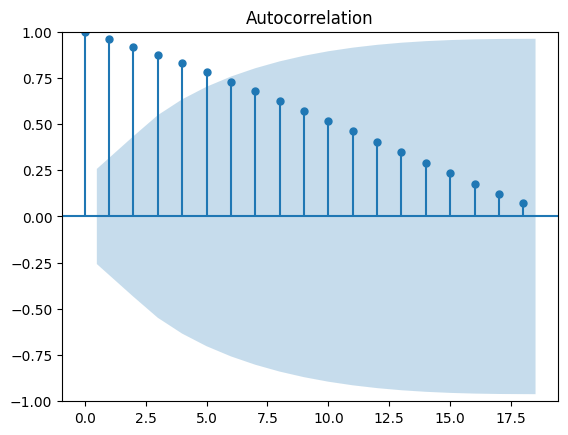

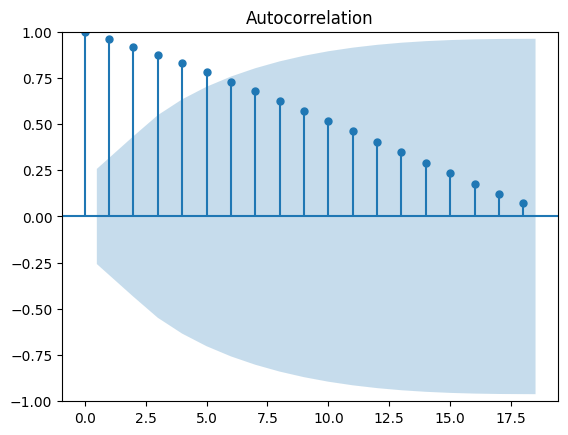

In [108]:
plot_acf(data[(data['Country']=="Mainland China") & (data['State']=="Hubei")][['Recovered']])

- Simple autocorrelation may indicate indirect relationship and hence is not of much use to us.

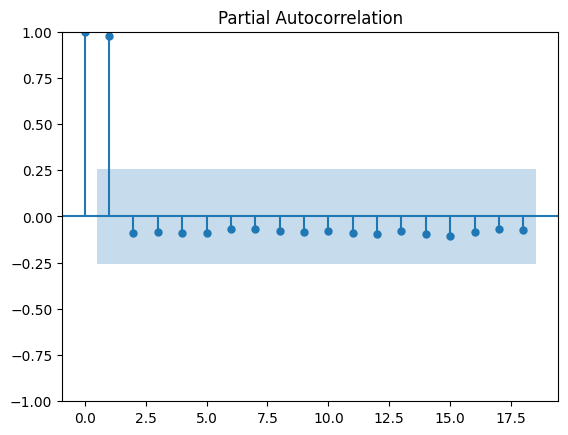

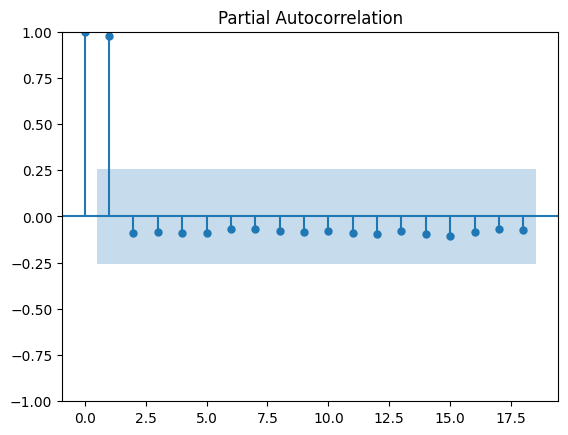

In [109]:
plot_pacf(data[(data['Country']=="Mainland China") & (data['State']=="Hubei")][['Recovered']])

- partial autocorrelation indicates that the day before is an important feature.So we will set our lag values to 1.

In [110]:
def simple_fe(df):
    
    df['year']=df['ds'].dt.year
    df['month']=df['ds'].dt.month
    df['day']=df['ds'].dt.day
    
    ##lag features
    df.loc[:,'rec_lag_2']=df.groupby(['Country','State'])['Recovered'].transform(lambda x: x.shift(1))
    df.loc[:,'conf_lag_2'] = df.groupby(['Country'])['Confirmed'].transform(lambda x: x.shift(1))
    df.loc[:,'deaths_lag_2'] =df.groupby(['Country'])['Deaths'].transform(lambda x: x.shift(1))
    
    ##rolling mean
    df['rec_rollmean_7']=df.groupby(['Country','State'])['Recovered'].transform(lambda x: x.rolling(7).mean())
    df['conf_rollmean_7'] = df.groupby(['Country'])['Confirmed'].transform(lambda x: x.rolling(7).mean())
    df['deaths_rollmean_7'] =df.groupby(['Country'])['Deaths'].transform(lambda x: x.rolling(7).mean())
    
    ##rolling std
    df['rec_rollstd_7']=df.groupby(['Country','State'])['Recovered'].transform(lambda x: x.rolling(7).std())
    df['conf_rollstd_7'] = df.groupby(['Country'])['Confirmed'].transform(lambda x: x.rolling(7).std())
    df['deaths_rollstd_7'] =df.groupby(['Country'])['Deaths'].transform(lambda x: x.rolling(7).std())
    
    #df.drop(['ds'],axis=1,inplace=True)
    df.fillna(0,inplace=True)
    
    return df
    

In [111]:
data= simple_fe(data)

In [112]:
def run_lgb(data,target):
    
    features=['year', 'month','State', 'Country','Recovered',
               'day', 'rec_lag_2', 'conf_lag_2', 'deaths_lag_2',
               'rec_rollmean_7', 'conf_rollmean_7', 'deaths_rollmean_7',
               'rec_rollstd_7', 'conf_rollstd_7', 'deaths_rollstd_7']
     
    train,test=train_test_split(data,7)
    x_train=train[features]
    y_train=train[target]
    print(x_train.shape)
    x_val=test[features]
    y_val=test[target]
    print(x_val.shape)

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 236,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}

    train_set = lgb.Dataset(x_train[features], y_train,categorical_feature=['State',"Country",'year','month','day'])
    val_set = lgb.Dataset(x_val[features], y_val,categorical_feature=['State',"Country",'year','month','day'])

    del x_train, y_train

    model = lgb.train(params, train_set, num_boost_round = 500, early_stopping_rounds = 50, valid_sets = [train_set, val_set],
                      verbose_eval = 100,)
    val_pred = model.predict(x_val[features])
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(val_score)

    #y_pred = model.predict(x_val)
    #test[targets] = y_pred.values
    return val_pred

- Note : Corrections will be fixed soon..

In [113]:
sub=pd.DataFrame()
sub['ds']=test['ds'].values
targets=['Confirmed', 'Deaths', 'Recovered']
for target in targets:
    
        sub[target]=run_lgb(data,target)

(4935, 15)
(1861, 15)
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 4935, number of used features: 14
[LightGBM] [Info] Start training from score 577.614590
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 329.901	valid_1's rmse: 1864.7
[200]	training's rmse: 217.33	valid_1's rmse: 1776.81
Early stopping, best iteration is:
[230]	training's rmse: 204.596	valid_1's rmse: 1749.01
1749.0084378900674
(4935, 15)
(1861, 15)
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-thread

In [114]:
sub.head()

,ds,Confirmed,Deaths,Recovered
0,2020-03-13,66975.511032,2883.008916,47159.350264
1,2020-03-13,2380.014174,76.749838,1253.168885
2,2020-03-13,1620.950441,78.027392,1559.718031
3,2020-03-13,1140.705967,27.218747,1451.331183
4,2020-03-13,1044.094690,22.234836,1258.875826
